In [1]:
import torch
import fastai.vision as fv
import fastai.basics as fai
import torch.nn as nn
import torch.nn.functional as F

import gc

from Layers import *
from PerceptualLoss import *

In [2]:
def load_data(path,size,bs):
    tfms = fv.get_transforms()
    return (fv.ImageImageList
            .from_folder(path)
            .split_by_rand_pct(0.05)
            .label_from_func(lambda file_name: file_name)
            .transform(tfms,size=size,tfm_y=True)
            .databunch(bs=64))

In [3]:
data = load_data("StyleGANsmall",128,128)

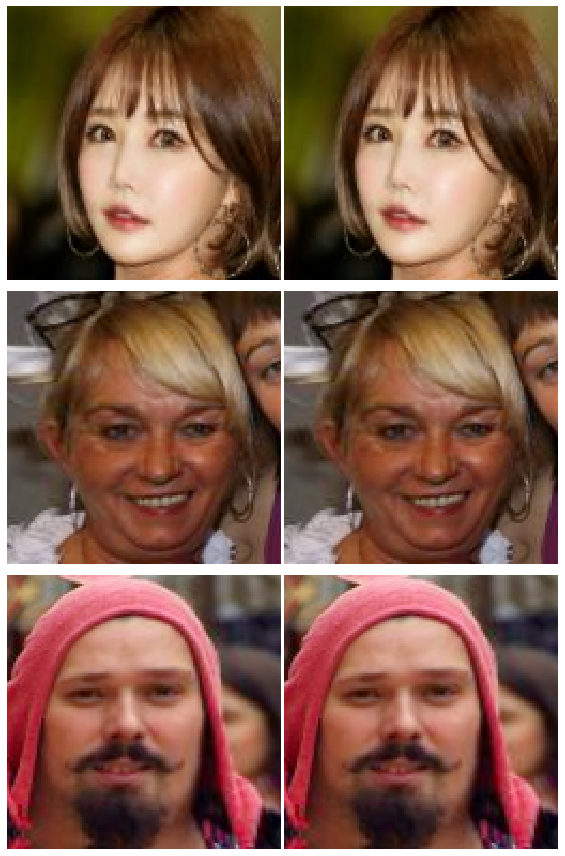

In [4]:
data.show_batch(rows=3)

In [5]:
class Restructure(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        bs,n = x.shape
        return x.view((bs,n//4,2,2))

In [6]:
def encoder(c_out):
    return nn.Sequential(
        NiceDownscale(3,32,k=6,activation=False),
        nn.MaxPool2d(2),
        concat_downscale(32,64),
        ResBlock(64),
        concat_downscale(64,128),
        ResBlock(128),
        concat_downscale(128,256),
        ResBlock(256),
        NiceDownscale(256,512),
        ResBlock(512),
        NiceDownscale(512,1024),
        fv.Flatten(),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Linear(1024,c_out),
        nn.Tanh()
    )

def decoder(c_in):
    return nn.Sequential(
        nn.BatchNorm1d(c_in),
        nn.Linear(c_in,1024),
        Restructure(), #2
        fv.PixelShuffle_ICNR(256,leaky=0.1),#4
        ResBlock(256),
        conv_block(256,512,k=1,s=1),
        fv.PixelShuffle_ICNR(512,256,leaky=0.1), #8
        ResBlock(256),
        conv_block(256,512,k=1,s=1),
        fv.PixelShuffle_ICNR(512,256,leaky=0.1), #16
        ResBlock(256),
        fv.PixelShuffle_ICNR(256,128,leaky=0.1), #32
        ResBlock(128),
        fv.PixelShuffle_ICNR(128,64,leaky=0.1,blur=True),#64
        ResBlock(64),
        fv.PixelShuffle_ICNR(64,32,leaky=0.1,blur=True), #128
        conv_block(32,3,k=1,s=1,pad=0),
        ResBlock(3),
        nn.Sigmoid()
    )

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.encoder = encoder(nf)
        self.decoder = decoder(nf)
    def forward(self, x):
        z = self.encoder(x)
        
        #w = z + torch.randn_like(z)*0.1 if self.training else z
        return self.decoder(z)

In [8]:
model = AutoEncoder(100)

In [9]:
num_params(model)

19089819

In [10]:
ploss = perceptual_loss([1,2,8,15,12,5]).cuda()

In [11]:
learn=fv.Learner(data,model,loss_func=F.l1_loss)

In [12]:
gc.collect()

13412

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


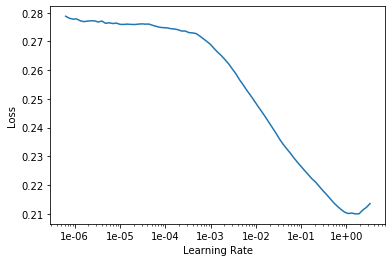

In [13]:
learn.lr_find(); learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5,1e-2,pct_start=0.2,final_div=100)

epoch,train_loss,valid_loss,time
0,0.109664,0.117641,02:11
1,0.099141,0.106305,02:09
2,0.090562,0.093407,02:08
3,0.086299,0.085725,02:09
4,0.084603,0.082755,02:10


In [15]:
learn.loss_func = ploss

In [16]:
learn.fit_one_cycle(15,1e-3,pct_start=0.2,final_div=80)

epoch,train_loss,valid_loss,time
0,2.972398,3.061595,04:26
1,2.864066,2.951727,04:27
2,2.809253,2.895705,04:27
3,2.765032,2.861601,04:28
4,2.752173,2.839511,04:28
5,2.727786,2.821876,04:28
6,2.720569,2.805342,04:29
7,2.697333,2.791126,04:29
8,2.691768,2.779795,04:28
9,2.678397,2.770887,04:29


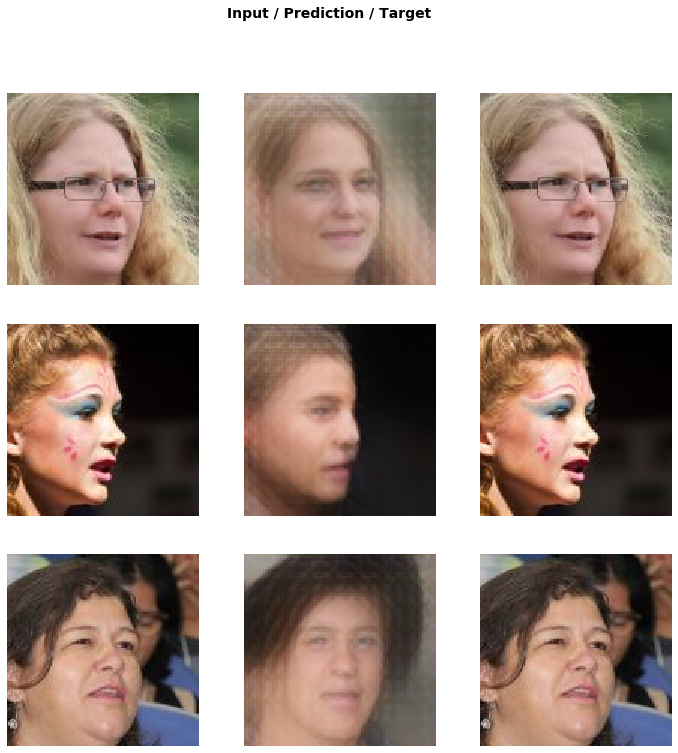

In [17]:
learn.show_results(rows=3)

In [18]:
learn.save('perceptual-225-1');